# Importing Necessary Libraries

In [62]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re

# File handling
import pickle

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Kaggle integration
import kagglehub

# Step 1: Import & Explore Dataset

In [ ]:
# Kaggle Dataset path
path = kagglehub.dataset_download("fahimvj/bengali-sms-spam-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 118k/118k [00:00<00:00, 65.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fahimvj/bengali-sms-spam-detection-dataset/versions/1


In [ ]:
# Load dataset
df = pd.read_csv(f"{path}/bangla_spam.csv")
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [ ]:
df

,type,text
0,spam,এই মেসেজটি শেয়ার করুন এবং জিতে নিন আকর্ষণীয় ...
1,spam,আপনার বন্ধুদের রেফার করুন এবং প্রতি রেফারেলে ২...
2,ham,ট্রানজ্যাকশন নম্বর R234321.1554.640085 20 টাকা...
3,spam,নতুন অফার! সীমিত সময়ের জন্য পণ্যের উপর ৯০% পর...
4,ham,নববর্ষের শুভেচ্ছা!! আল্লাহ আপনার সকল কষ্ট দূর ...
...,...,...
2597,spam,প্রতিদিন ১০০ টাকা জিততে চান? এখনই অংশগ্রহণ করুন!
2598,spam,মোবাইল অ্যাপ ডাউনলোড করুন এবং ৫০০ টাকা বোনাস পান!
2599,spam,"নতুন গ্রাহকদের জন্য বিশেষ অফার, আজই উপভোগ করুন!"
2600,spam,আপনার অ্যাকাউন্ট আপগ্রেড করুন এবং এক্সক্লুসিভ ...


In [ ]:
# --- Explore Dataset ---
# Shape of dataset
print("Shape of dataset:", df.shape)

Shape of dataset: (2602, 2)


In [ ]:
# Info about columns
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602 entries, 0 to 2601
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    2602 non-null   object
 1   text    2602 non-null   object
dtypes: object(2)
memory usage: 40.8+ KB
None


# Step 2: Preprocessing with pandas

In [ ]:
# Check for null values
print("\nNull values in each column:")
print(df.isnull().sum())


Null values in each column:
type    0
text    0
dtype: int64


In [ ]:
# Check for duplicates
print("\nDuplicate rows:", df.duplicated().sum())


Duplicate rows: 25


In [ ]:
# Remove duplicate rows (keep the first occurrence by default)
df = df.drop_duplicates()

In [ ]:
df.shape

(2577, 2)

In [ ]:
# Class distribution
print("\nClass distribution:")
print(df['type'].value_counts())
print("\nClass distribution (%):")
print(df['type'].value_counts(normalize=True) * 100)


Class distribution:
type
spam    1399
ham     1178
Name: count, dtype: int64

Class distribution (%):
type
spam    54.287932
ham     45.712068
Name: proportion, dtype: float64


/tmp/ipython-input-3901349466.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='Set2')


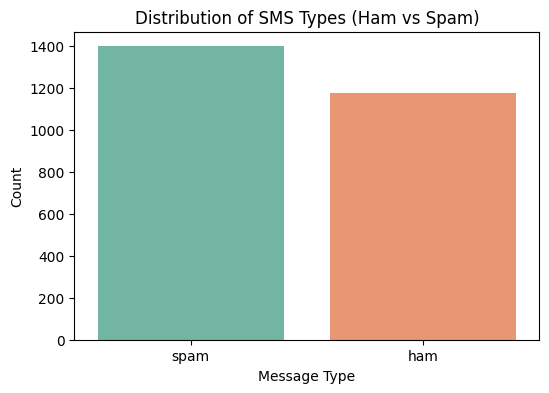

In [ ]:
# --- Visualization ---
plt.figure(figsize=(6,4))
sns.countplot(x='type', data=df, palette='Set2')
plt.title("Distribution of SMS Types (Ham vs Spam)")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

In [ ]:
# --- Encode labels ---
df['label'] = df['type'].map({'ham': 0, 'spam': 1})

/tmp/ipython-input-2110052569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['type'].map({'ham': 0, 'spam': 1})


In [ ]:
df.head()

,type,text,label
0,spam,এই মেসেজটি শেয়ার করুন এবং জিতে নিন আকর্ষণীয় ...,1
1,spam,আপনার বন্ধুদের রেফার করুন এবং প্রতি রেফারেলে ২...,1
2,ham,ট্রানজ্যাকশন নম্বর R234321.1554.640085 20 টাকা...,0
3,spam,নতুন অফার! সীমিত সময়ের জন্য পণ্যের উপর ৯০% পর...,1
4,ham,নববর্ষের শুভেচ্ছা!! আল্লাহ আপনার সকল কষ্ট দূর ...,0


In [ ]:
# --- Preprocessing function ---
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r"http\S+|www\S+", "<URL>", text)   # replace URLs
    text = re.sub(r"\+?\d{10,13}", "<PHONE>", text)   # replace phone numbers
    text = re.sub(r"\d+", "<NUM>", text)              # replace numbers
    text = re.sub(r"[^\w\s]", " ", text)              # remove punctuation/symbols
    text = re.sub(r"\s+", " ", text).strip()          # remove extra spaces
    return text

In [ ]:
# --- Apply cleaning ---
df['clean_text'] = df['text'].apply(clean_text)

/tmp/ipython-input-2316920404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(clean_text)


In [ ]:
# --- Check results ---
df[['text', 'clean_text', 'label']].head(10)

,text,clean_text,label
0,এই মেসেজটি শেয়ার করুন এবং জিতে নিন আকর্ষণীয় ...,এই ম স জট শ য র কর ন এব জ ত ন ন আকর ষণ য প রস ক র,1
1,আপনার বন্ধুদের রেফার করুন এবং প্রতি রেফারেলে ২...,আপন র বন ধ দ র র ফ র কর ন এব প রত র ফ র ল NUM ...,1
2,ট্রানজ্যাকশন নম্বর R234321.1554.640085 20 টাকা...,ট র নজ য কশন নম বর r NUM NUM NUM NUM ট ক র চ র...,0
3,নতুন অফার! সীমিত সময়ের জন্য পণ্যের উপর ৯০% পর...,নত ন অফ র স ম ত সময র জন য পণ য র উপর NUM পর য...,1
4,নববর্ষের শুভেচ্ছা!! আল্লাহ আপনার সকল কষ্ট দূর ...,নববর ষ র শ ভ চ ছ আল ল হ আপন র সকল কষ ট দ র কর ...,0
5,আপনার ইমেইল যাচাই করুন এবং ২০০০ টাকা বোনাস জিতুন!,আপন র ইম ইল য চ ই কর ন এব NUM ট ক ব ন স জ ত ন,1
6,নতুন গ্যাজেট কিনুন এবং ১০% ক্যাশব্যাক পান!,নত ন গ য জ ট ক ন ন এব NUM ক য শব য ক প ন,1
7,আপনার মোবাইল রিচার্জ করুন এবং ১৫% ক্যাশব্যাক পান!,আপন র ম ব ইল র চ র জ কর ন এব NUM ক য শব য ক প ন,1
8,বিশেষ ছাড়! সব পণ্যের উপর ৯৫% পর্যন্ত ডিসকাউন্ট!,ব শ ষ ছ ড সব পণ য র উপর NUM পর যন ত ড সক উন ট,1
9,আজই ক্লিক করুন এবং ৫০০০ টাকা জিতুন!,আজই ক ল ক কর ন এব NUM ট ক জ ত ন,1


In [ ]:
df.shape

(2577, 4)

# Step 3: Feature Engineering + Train/Test Split

In [ ]:
# --- Features (X) and Labels (y) ---
X = df['clean_text']
y = df['label']

In [ ]:
# --- Train-Test Split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
X_train

,clean_text
1656,ল য পটপ র খছ ল ম ক ন মন ন ই ক ন ত ল য পটপ ত ব স য়
706,ব ল দ শ ন ব হ ন ত অফ স র ক য ড ট পদ ন য় গ চলছ ...
122,প রত দ ন NUM ট ক র ক ন ক ট য় NUM ট ক ক য শব য ক
974,ড ট NUM ও ম ন ট NUM NUM প য় ছ ন
1995,এগ ল যদ জ ন ত প র আম দ রক ক ভ বব ভ ব দ খ
...,...
2466,মন হয় ত র ম য ন জ র ত র এই ছ ট ট pd ক জ ন য় ন ...
114,প রত দ ন NUM ট ক র ক ন ক ট য় ফ র ড ল ভ র
1003,আজ NUM জ ব NUM দ ন র জন য NUM ট ক য় ড য় ল NUM NUM
1544,ঈদ ক ন ক ট হ ক ড য়মন ড ওয় র ল ড র স থ উপভ গ কর...


In [ ]:
y_train

,label
1656,0
706,0
122,1
974,1
1995,0
...,...
2466,0
114,1
1003,1
1544,1


In [ ]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 2061
Testing samples: 516


In [ ]:
# --- TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=5000,   # limit vocabulary size for speed
    ngram_range=(1,2),   # use unigrams + bigrams (captures short spam patterns)
    sublinear_tf=True    # reduces impact of very frequent words
)

In [ ]:
# Fit on training data and transform both train & test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
print("TF-IDF Matrix (train):", X_train_tfidf.shape)
print("TF-IDF Matrix (test):", X_test_tfidf.shape)

TF-IDF Matrix (train): (2061, 5000)
TF-IDF Matrix (test): (516, 5000)


# Step 4: Training baseline models

In [ ]:
# --- Define models ---
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": LinearSVC(class_weight='balanced')
}

In [ ]:
# --- Train & Evaluate ---
for name, model in models.items():
    print(f"\n===== {name} =====")
    # Train
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


===== Naive Bayes =====
Accuracy: 0.9496124031007752

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      0.92      0.94       236
        Spam       0.93      0.97      0.95       280

    accuracy                           0.95       516
   macro avg       0.95      0.95      0.95       516
weighted avg       0.95      0.95      0.95       516

Confusion Matrix:
[[217  19]
 [  7 273]]

===== Logistic Regression =====
Accuracy: 0.9573643410852714

Classification Report:
              precision    recall  f1-score   support

         Ham       0.95      0.95      0.95       236
        Spam       0.96      0.96      0.96       280

    accuracy                           0.96       516
   macro avg       0.96      0.96      0.96       516
weighted avg       0.96      0.96      0.96       516

Confusion Matrix:
[[225  11]
 [ 11 269]]

===== SVM =====
Accuracy: 0.9748062015503876

Classification Report:
              precision    rec

In [ ]:
# Store results
results = []

for name, model in models.items():
    # Train
    model.fit(X_train_tfidf, y_train)
    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)   # binary F1 (spam is 1)

    results.append({"Model": name, "Accuracy": acc, "F1-Score": f1})

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\nModel Performance:")
print(results_df)


Model Performance:
                 Model  Accuracy  F1-Score
0          Naive Bayes  0.949612  0.954545
1  Logistic Regression  0.957364  0.960714
2                  SVM  0.974806  0.976661


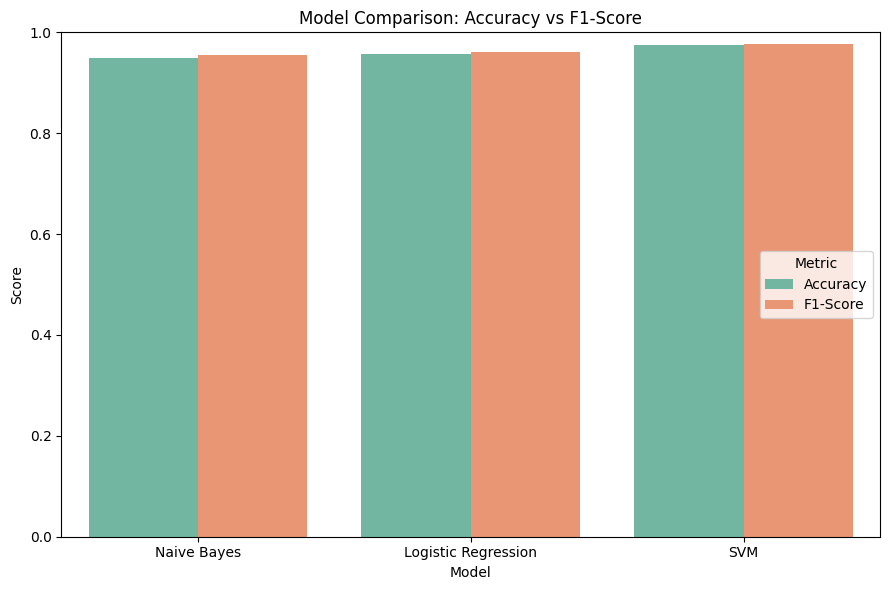

In [72]:
# Reshape dataframe into long format
plot_df = results_df.melt(id_vars="Model", value_vars=["Accuracy", "F1-Score"],
                          var_name="Metric", value_name="Score")

# --- Visualization ---
plt.figure(figsize=(9,6))
sns.barplot(x="Model", y="Score", hue="Metric", data=plot_df, palette="Set2", dodge=0.7)

plt.title("Model Comparison: Accuracy vs F1-Score")
plt.ylabel("Score")
plt.ylim(0, 1)  # scores between 0 and 1
plt.legend(title="Metric", loc="center right")
plt.tight_layout()
plt.show()

# Step 5: Find the best model & Save it

In [ ]:
best_model = None
best_score = 0
best_name = ""

for name, model in models.items():
    # Train
    model.fit(X_train_tfidf, y_train)
    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Track best model by Accuracy
    if acc > best_score:
        best_model = model
        best_score = acc
        best_name = name

print(f"\n✅ Best Model: {best_name} with Accuracy = {best_score:.4f}")


✅ Best Model: SVM with Accuracy = 0.9748


In [ ]:
# --- Save the best model using pickle ---
with open("best_spam_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# --- Save the TF-IDF vectorizer too (needed for preprocessing) ---
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("📦 Best model and TF-IDF vectorizer saved successfully!")

📦 Best model and TF-IDF vectorizer saved successfully!


# Step 6: loading the saved model & testing on new SMS messages.

In [ ]:
# --- Load saved model and vectorizer ---
with open("best_spam_model.pkl", "rb") as f:
    best_model = pickle.load(f)

with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

In [ ]:
# --- Preprocessing function (same as before) ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "<URL>", text)   # replace URLs
    text = re.sub(r"\+?\d{10,13}", "<PHONE>", text)   # replace phone numbers
    text = re.sub(r"\d+", "<NUM>", text)              # replace numbers
    text = re.sub(r"[^\w\s]", " ", text)              # remove punctuation/symbols
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
# --- Prediction function ---
def predict_sms(message):
    # Preprocess
    cleaned = clean_text(message)
    # Vectorize
    features = tfidf.transform([cleaned])
    # Predict
    prediction = best_model.predict(features)[0]
    label = "Spam" if prediction == 1 else "Ham"
    return label

In [ ]:
# --- Test with some examples ---
samples = [
    "আপনার বিকাশ একাউন্টে টাকা পাঠানো হয়েছে।",
    "Free offer!!! Click this link to win a prize http://spam.com",
    "মিটিং কাল দুপুর ২টায় হবে। সবাই আসবেন।"
]

In [ ]:
for msg in samples:
    print(f"Message: {msg}")
    print("Prediction:", predict_sms(msg))
    print("-" * 50)


Message: আপনার বিকাশ একাউন্টে টাকা পাঠানো হয়েছে।
Prediction: Spam
--------------------------------------------------
Message: Free offer!!! Click this link to win a prize http://spam.com
Prediction: Spam
--------------------------------------------------
Message: মিটিং কাল দুপুর ২টায় হবে। সবাই আসবেন।
Prediction: Ham
--------------------------------------------------
